In [1]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.preprocessing import image

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


# 图片生成器

图片生成器可以让我们在训练模型的时候实时预处理图片。

在数据集巨大的时候，使用图片生成器是很有用的。

我们预处理的操作是将图片转灰色，归一化和 reshape 为28\*28

In [2]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1.0/255)
train_generator = train_datagen.flow_from_directory(
    'train',  # this is the target directory
    classes=map(str, range(11)),
    color_mode='grayscale',
    target_size=(28,28),
    batch_size=128,
    class_mode='categorical')

validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(
    'valid',  # this is the target directory
    classes=map(str, range(11)),
    color_mode='grayscale',
    target_size=(28,28),
    batch_size=128,
    class_mode='categorical')

Found 56685 images belonging to 11 classes.
Found 6303 images belonging to 11 classes.


# 数据集概览

让我们显示几张由图片生成器生成的一批图片。

可以看到0~9被分为了0~9类，非数字被分为了第10类。

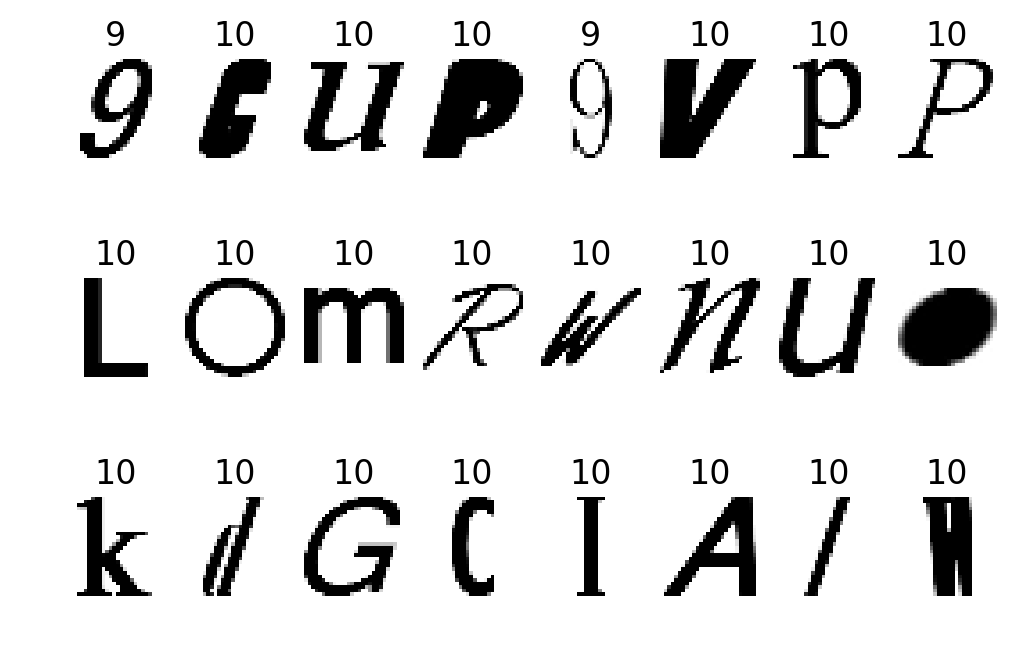

In [3]:
x, y = train_generator.next()

for i, (img, label) in enumerate(zip(x, y)[:24]):
    plt.subplot(3, 8, i+1)
    plt.title(str(np.argmax(label)))
    plt.axis('off')
    plt.imshow(img[:,:,0], interpolation="nearest", cmap='gray')

# 构建模型

我们的模型结构很简单，784->512->512->11

In [4]:
model = Sequential()
model.add(Flatten(input_shape=(28, 28, 1)))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(11))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
flatten_1 (Flatten)              (None, 784)           0           flatten_input_1[0][0]            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 512)           401920      flatten_1[0][0]                  
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 512)           0           dense_1[0][0]                    
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 512)           0           activation_1[0][0]               
___________________________________________________________________________________________

# 训练

In [5]:
model.fit_generator(
        train_generator,
        samples_per_epoch=51200,
        nb_epoch=10,
        validation_data=validation_generator,
        nb_val_samples=5120)

Epoch 1/10
51200/51200 [==============================] - 42s - loss: 0.3604 - acc: 0.9087 - val_loss: 0.2007 - val_acc: 0.9404
Epoch 2/10
51181/51200 [============================>.] - ETA: 0s - loss: 0.1852 - acc: 0.9489

/usr/local/lib/python2.7/site-packages/keras/engine/training.py:1462: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


51309/51200 [==============================] - 28s - loss: 0.1849 - acc: 0.9490 - val_loss: 0.1552 - val_acc: 0.9526
Epoch 3/10
51309/51200 [==============================] - 27s - loss: 0.1511 - acc: 0.9569 - val_loss: 0.1413 - val_acc: 0.9563
Epoch 4/10
51309/51200 [==============================] - 28s - loss: 0.1328 - acc: 0.9617 - val_loss: 0.1055 - val_acc: 0.9680
Epoch 5/10
51309/51200 [==============================] - 27s - loss: 0.1151 - acc: 0.9659 - val_loss: 0.1274 - val_acc: 0.9645
Epoch 6/10
51309/51200 [==============================] - 27s - loss: 0.1117 - acc: 0.9654 - val_loss: 0.1290 - val_acc: 0.9625
Epoch 7/10
51309/51200 [==============================] - 28s - loss: 0.1011 - acc: 0.9692 - val_loss: 0.1083 - val_acc: 0.9666
Epoch 8/10
51309/51200 [==============================] - 28s - loss: 0.0941 - acc: 0.9705 - val_loss: 0.0976 - val_acc: 0.9709
Epoch 9/10
51309/51200 [==============================] - 27s - loss: 0.0883 - acc: 0.9726 - val_loss: 0.0981 - val

In [6]:
with open('model.json', 'w') as f:
    f.write(model.to_json())
model.save_weights('model.h5', overwrite=True)

# 测试模型

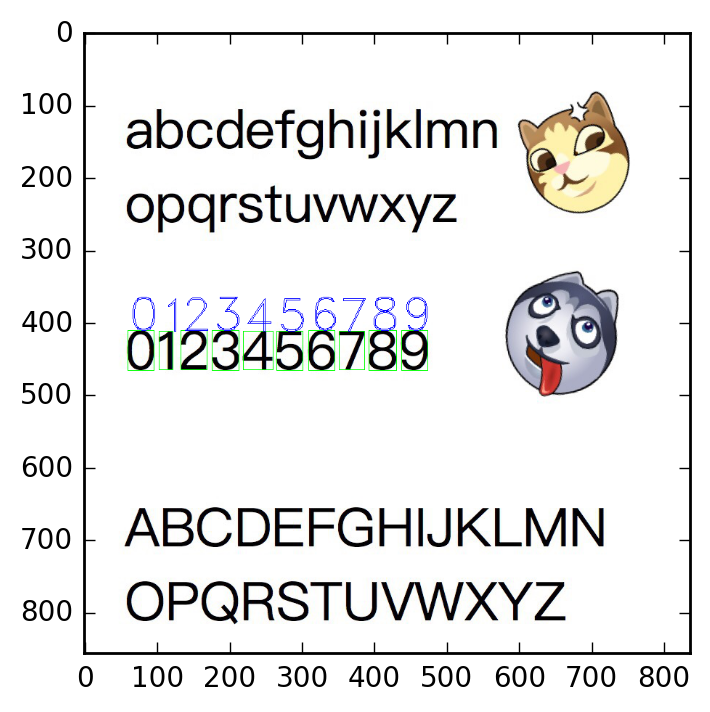

In [7]:
def resize(rawimg):  # resize img to 28*28
    fx = 28.0 / rawimg.shape[0]
    fy = 28.0 / rawimg.shape[1]
    fx = fy = min(fx, fy)
    img = cv2.resize(rawimg, None, fx=fx, fy=fy, interpolation=cv2.INTER_CUBIC)
    outimg = np.ones((28, 28), dtype=np.uint8) * 255
    w = img.shape[1]
    h = img.shape[0]
    x = (28 - w) / 2
    y = (28 - h) / 2
    outimg[y:y+h, x:x+w] = img
    return outimg


def convert(imgpath):   # read digits
    img = cv2.imread(imgpath)
    gray = cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE)
    bw = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 25, 25)
    img2, ctrs, hier = cv2.findContours(bw.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rects = [cv2.boundingRect(ctr) for ctr in ctrs]

    for rect in rects:
        x, y, w, h = rect
        roi = gray[y:y+h, x:x+w]
        hw = float(h) / w
        if (w < 200) & (h < 200) & (h > 10) & (w > 10) & (1.1 < hw) & (hw < 5):
            res = resize(roi)
            res = np.resize(res, (1, 28, 28, 1))

            predictions = model.predict(res)
            predictions = np.argmax(predictions)
            if predictions != 10:
                cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 1)
                cv2.putText(img, '{:.0f}'.format(predictions), (x, y), cv2.FONT_HERSHEY_DUPLEX, h/25.0, (255, 0, 0))
    return img

plt.imshow(convert('test.png')[:,:,::-1])